In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import re
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [191]:
df = pd.read_csv('./SeoulBikeData.csv', encoding= 'unicode_escape').drop(["Date", "Seasons", "Holiday"], axis=1)

In [192]:
dataset_cols = []
for col in df.columns:
    col_name = col
    col_name.replace(" ", "_")
    col_name = re.sub('[^A-Za-z0-9_]+', '', col_name)
    dataset_cols.append(col_name)

df.columns = dataset_cols

In [193]:
df["FunctioningDay"] = (df["FunctioningDay"] == "Yes").astype(int)
df = df[df["Hour"] == 12]
df = df.drop(["Hour","Windspeedms", "Visibility10m", "FunctioningDay"], axis=1)

In [214]:
df.head()

RentedBikeCount  TemperatureC  Humidity  DewpointtemperatureC   
12               449           1.7        23                 -17.2  \
36               479           4.3        41                  -7.8   
60               333           5.8        85                   3.4   
84               393          -0.3        38                 -12.9   
108              321          -2.3        25                 -19.7   

     SolarRadiationMJm2  Rainfallmm  Snowfallcm  
12                 1.11         0.0         0.0  
36                 1.09         0.0         0.0  
60                 0.43         0.0         0.0  
84                 1.11         0.0         0.0  
108                0.00         0.0         0.0

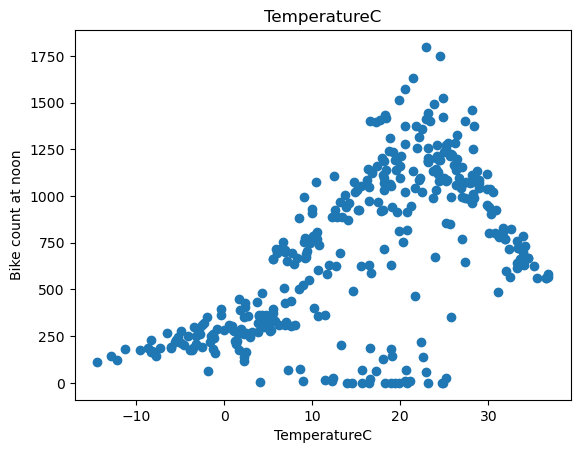

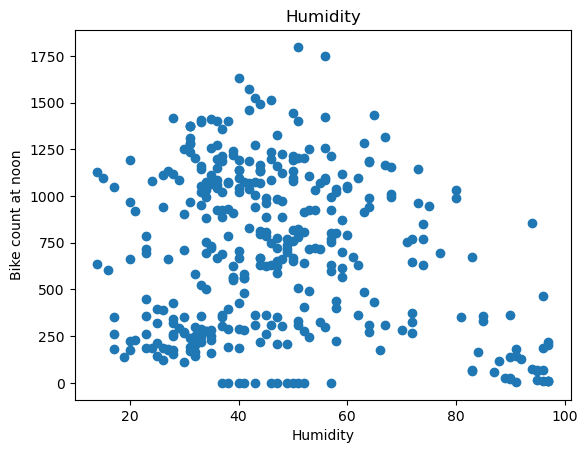

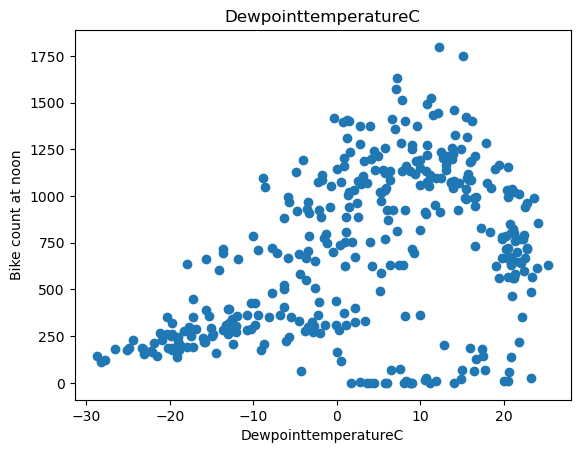

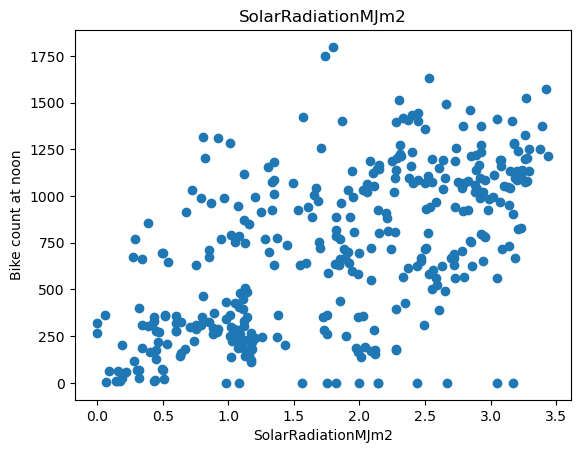

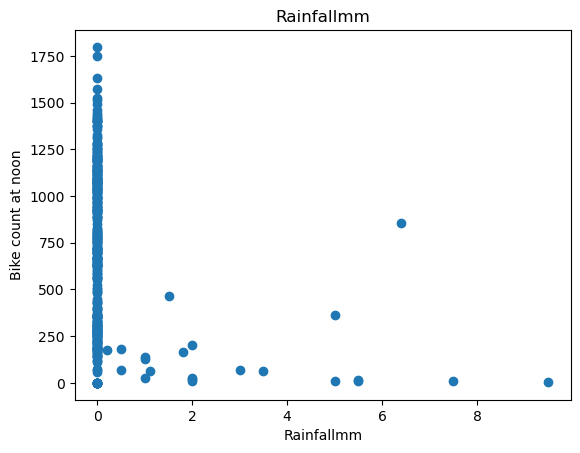

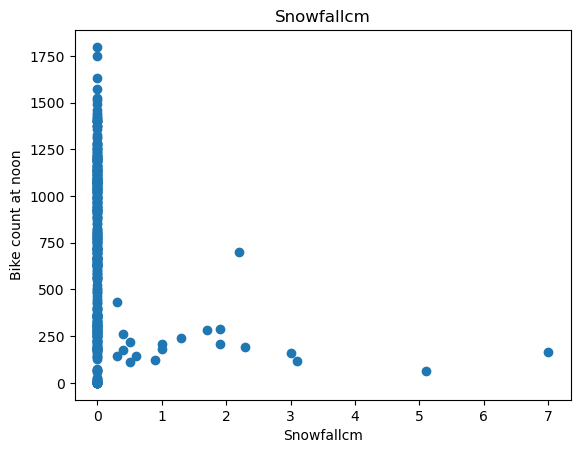

In [195]:
for label in df.columns[1:]:
    plt.scatter(df[label], df["RentedBikeCount"])
    plt.title(label)
    plt.ylabel("Bike count at noon")
    plt.xlabel(label)
    plt.show()


In [196]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [197]:
def get_xy(dataframe, y_label, x_labels=None):
    dataframe = copy.deepcopy(dataframe)
    if x_labels is None:
        X = dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels) == 1:
            X = dataframe[x_labels[0]].values.reshape(-1, 1)
        else:
            X = dataframe[x_labels].values
            
    y = dataframe[y_label].values.reshape(-1, 1)
    data = np.hstack((X, y))
    
    return data, X, y

In [198]:
_, X_train_temp, y_train_temp = get_xy(df, "RentedBikeCount", x_labels=["TemperatureC"])
_, X_val_temp, y_val_temp = get_xy(val, "RentedBikeCount", x_labels=["TemperatureC"])
_, X_test_temp, y_test_temp = get_xy(test, "RentedBikeCount", x_labels=["TemperatureC"])

In [199]:
temp_reg = LinearRegression()
temp_reg.fit(X_train_temp, y_train_temp)

LinearRegression()

In [200]:
temp_reg.score(X_test_temp, y_test_temp)

0.3863708434555251

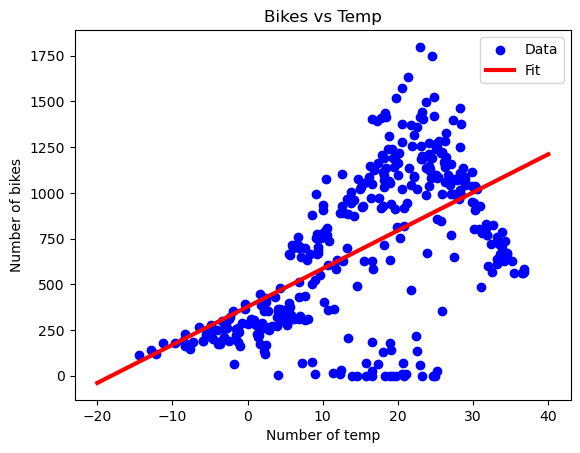

In [201]:
plt.scatter(X_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of bikes")
plt.xlabel("Number of temp")
plt.show()

In [212]:
_, X_train_all, y_train_all = get_xy(df, "RentedBikeCount", x_labels=df.columns[1:])
_, X_val_all, y_val_all = get_xy(val, "RentedBikeCount", x_labels=df.columns[1:])
_, X_test_all, y_test_all = get_xy(test, "RentedBikeCount", x_labels=df.columns[1:])

X_val_all.shape

(73, 6)

In [203]:
all_reg = LinearRegression()
all_reg.fit(X_train_all, y_train_all)

LinearRegression()

In [204]:
all_reg.score(X_test_all, y_test_all)

0.5741451537929638

In [205]:
# Regression with NN

In [216]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

In [217]:
temp_normalizer = tf.keras.layers.Normalization(axis=None)

In [218]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [219]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1), loss='mean_squared_error')

In [220]:
history = temp_nn_model.fit(
    X_train_all, y_train_all,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_all, y_val_all)
)

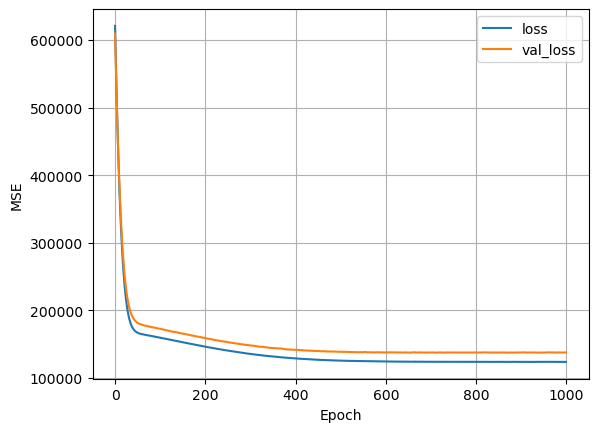

In [185]:
plot_loss(history)

In [224]:
temp_normalizer = tf.keras.layers.Normalization(axis=None)

nn_model = temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

nn_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), loss='mean_squared_error')

history = nn_model.fit(
    X_train_temp, y_train_temp,
    validation_data=(X_val_temp, y_val_temp),
    verbose=0, epochs=100
)

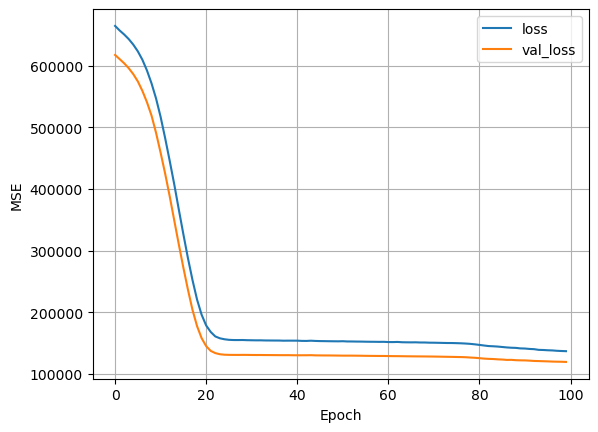

In [225]:
plot_loss(history)